In [1]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from intvalpy import lineqs

import os, sys
sys.path.append('../')
from src import functions
from src import trainer
from src import models
from src import utils

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()

## Data

In [2]:
# Set data function
data = utils.DataGenerator# Could be 'convex' or 'franke'

x, y = data.convex()
xt, yt = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [3]:
# print shapes
print(f"x shape: {x.shape}, y shape: {y.shape}")


x shape: (10000, 2), y shape: (10000, 1)


In [4]:
def visualize_data(x, y):
    # plot in 3d
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection='3d')
    surface = ax.plot_trisurf(x[:, 0], x[:, 1], y.flatten(), cmap='viridis', edgecolor='none')
    ax = fig.add_subplot(122)
    scat = ax.scatter(x[:,0], x[:,1], c=y, cmap='viridis')
    # colorbar for the scatter plot
    cbar = plt.colorbar(scat, ax=ax)
    cbar.set_label('Target Value')
    plt.title('3D Scatter Plot of Generated Data')
    plt.show()

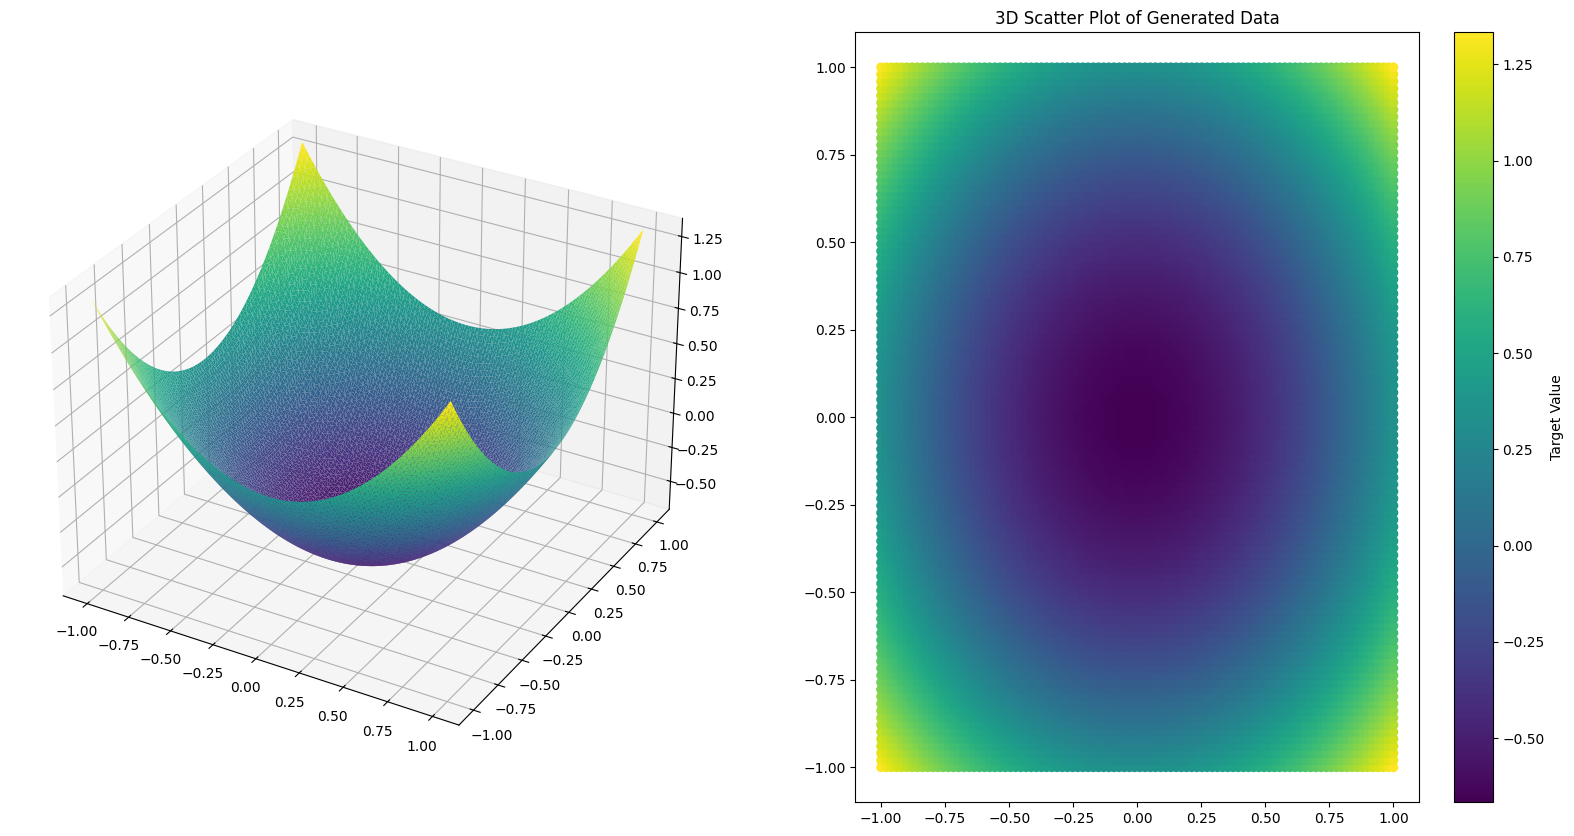

In [5]:
visualize_data(x, y)

In [6]:
# Train model

EPOCHS = 5000
criterion = nn.MSELoss()

model = utils.NeuralNet(input_size=2, num_classes=1, hidden_sizes=[3,3])

# Try to load a pre-trained model
try:
    model.load_state_dict(torch.load('../model_convex.pth'))
    print("Loaded pre-trained model.")
except FileNotFoundError:
    print("No pre-trained model found, training from scratch.")
    optimizer = torch.optim.Adam(model.parameters())
    losses = []

    for epoch in trange(EPOCHS):
        model.train()
        optimizer.zero_grad()

        out = model(xt)
        loss = criterion(out, yt)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        optimizer.zero_grad()
    # Save the trained model
    torch.save(model.state_dict(), '../model_convex.pth')

    plt.figure(1)
    plt.plot(losses)
    plt.show()

Loaded pre-trained model.


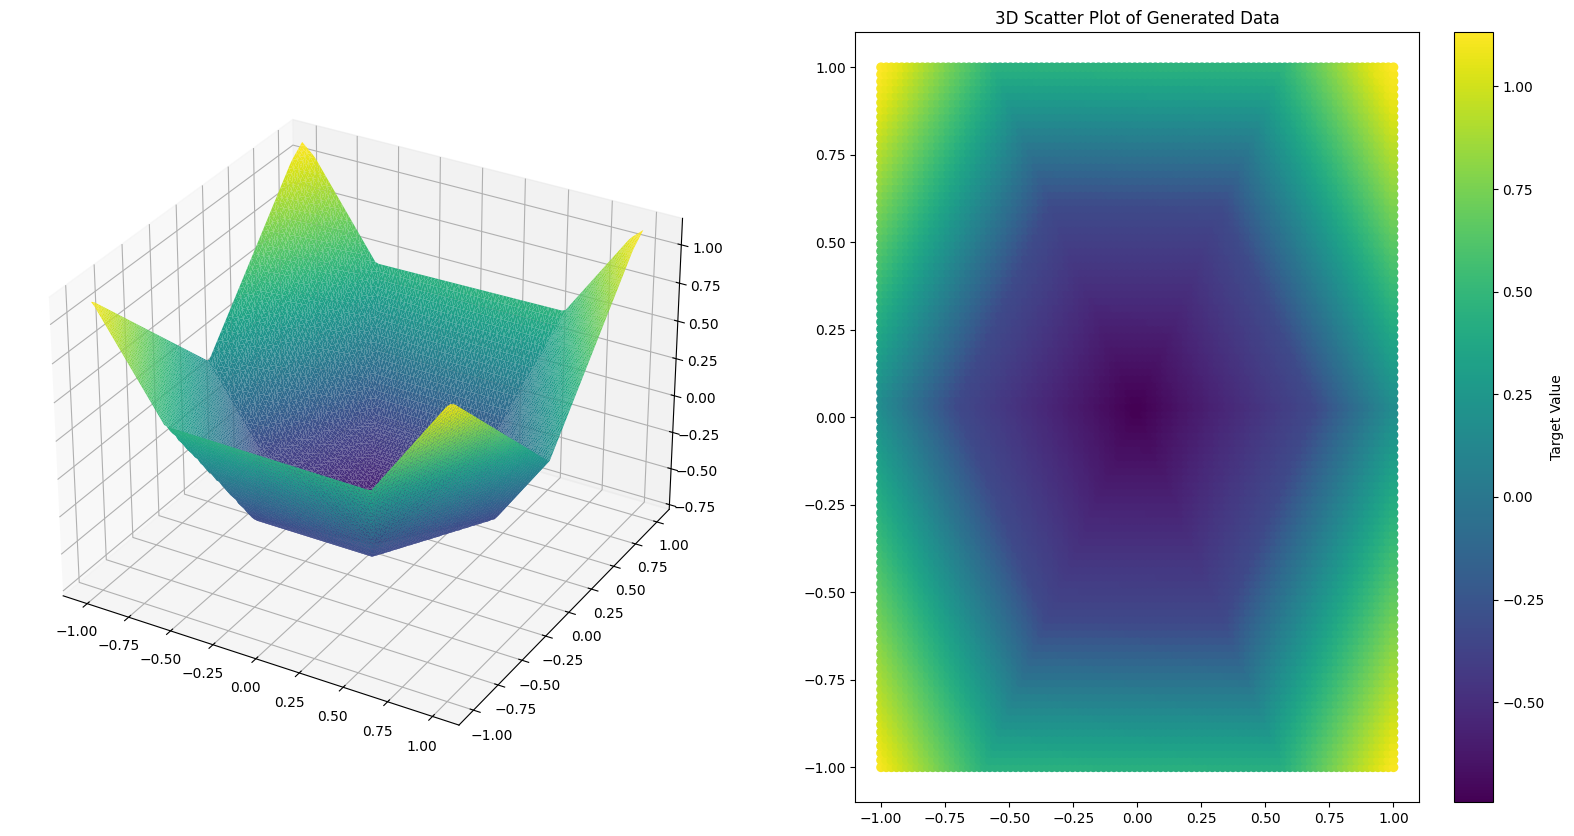

In [7]:
model.eval()
visualize_data(to_np(xt), to_np(model(xt)))

In [8]:
np.random.seed(124)
rand_idx = np.random.randint(0, xt.shape[0])
random_sample = to_np(xt[rand_idx].unsqueeze(0).T)
print("Random sample:\n ", random_sample)

A_random_sample, c_random_sample, [random_sample_bit_vector_list] = functions.get_inequalities(model,random_sample,return_bit_vec_list=True, input_dimension=2 )
        
indexes_for_active_bits_random_sample, stats = functions.active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )

# random_sample_bit_vector_list = functions.bit_vector_from_relus(model, random_sample.reshape(-1,1), get_unique_bit_vectors_only=True)
# random_sample_bit_vector=np.vstack(random_sample_bit_vector_list[0])

polytope_list, active_bit_count_list  = functions.get_polytope_list(random_sample_bit_vector_list, indexes_for_active_bits_random_sample, input_dimension=2, model=model)

bit_string_list_from_alg = polytope_list

def divide_column_vector(column_vector):
    return np.array_split(column_vector, 2)

list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

A_alg, c_alg = functions.get_inequalities(model,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2)
len(A_alg)


verticles_list_alg = []

bound = 2


def find_verticles(A, c):
    # Find the boundaries of the polytope defined by Ax <= c
    for A, c in zip (A_alg, c_alg):
        verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
        verticles_list_alg.append(verticles)
    return verticles_list_alg

counter = 1
c_max = 500
while counter <= c_max:
    try:
        verticles_list_alg = find_verticles(A_alg, c_alg)
        print(f"Found {len(verticles_list_alg)} vertices\nBound: {bound}\nCounter: {counter}")
        break
    except IndexError:
        counter += 1
        bound = 2**counter
    if counter == c_max:
        print(f"Failed to find vertices after {c_max} attempts. Last bound was: {bound:.2e}")



Random sample:
  [[ 0.17171717]
 [-0.09090909]]
Found 168 vertices
Bound: 512
Counter: 9


In [9]:
print(verticles_list_alg[0])
print(verticles_list_alg[1])

[[-1.25490589e-04  1.93804532e-02]
 [ 8.37506790e-03  3.40088101e-02]
 [ 7.01732641e-01  2.83385555e-02]
 [ 3.42325797e-01 -5.90153938e-01]]
[[ 0.00837507  0.03400881]
 [-0.00012549  0.01938045]
 [-0.00842123  0.03414617]]


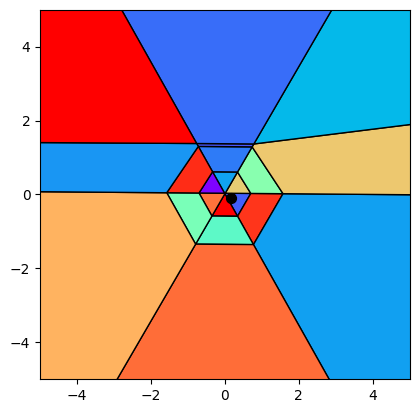

The number of polytopes within the boundaries is: 166


In [16]:
bound *= 1.1
bound = 5

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
patches = []
num_polygons = len(verticles_list_alg)
colors = [np.random.randint(1, 300) for i in range(num_polygons)]
cmap = matplotlib.colormaps['rainbow']

polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


# for i in range(num_polygons):
for i in range(num_polygons):
    vertices_i = verticles_list_alg[i]
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
#     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=vertices_i,
                          closed=True,
                          facecolor=cmap(colors[i]),
                          edgecolor='black',
                        #   label=np.transpose(bit_string_list_from_alg[i])[0],
                         )
        ax.add_patch(polygon)
    
        patches.append(polygon)
        
        polytopes_within_boundaries += 1

        
        

ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
# Show random sample point
ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# np.random.seed(10)
colors = [np.random.randint(1, 1000) for i in range(len(patches))]
plt.show()

print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")

In [47]:
# len(verticles_list_alg)

# unique polytopes
# for poly in list(verticles_list_alg):
    # print(tuple(poly.tolist()))
    
total_elements = set()
for poly in list(verticles_list_alg):
    vertices = tuple(map(tuple, poly.tolist()))  # Convert to tuple of tuples for immutability
    total_elements.add(vertices)
    
print(len(total_elements))

48
